In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np 
import pandas as pd 
from sklearn.model_selection import train_test_split

In [2]:
print("Num of GPUs:", torch.cuda.device_count())
print("GPU tagger is:", torch.cuda.current_device())
print("GPU model:", torch.cuda.get_device_name(0))

Num of GPUs: 1
GPU tagger is: 0
GPU model: Tesla P100-PCIE-16GB


In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Assuming that we are on a CUDA machine, this should print a CUDA device:

print(device)

cuda:0


In [4]:
if device.type == 'cuda':
    print('Memory Usage:')
    print('Allocated:', round(torch.cuda.memory_allocated(0)/1024**3,1), 'GB')
    print('Cached:   ', round(torch.cuda.memory_cached(0)/1024**3,1), 'GB')

Memory Usage:
Allocated: 0.0 GB
Cached:    0.0 GB


In [5]:
torch.version.cuda

'9.2.148'

In [6]:
torch.cuda.empty_cache()

# Reading the data:

In [7]:
df_bkg = pd.read_csv('/afs/desy.de/user/m/mokhtarf/Data/MultiClass_background.csv')
df_sig = pd.read_csv('/afs/desy.de/user/m/mokhtarf/Data/MultiClass_signal.csv')

df_sig.loc[:,'Y'] = 1
df_bkg.loc[:,'Y'] = 0

In [8]:
df = pd.DataFrame()
df = pd.concat([df_sig,df_bkg],sort=False)

In [9]:
df.head()

,MET,MT,Jet2_pt,Jet1_pt,nLep,Lep_pt,Selected,nVeto,LT,HT,...,GenMET,Lep_relIso,Lep_miniIso,iso_pt,iso_MT2,mGo,mLSP,filename,Finalweight,Y
0,111.84463,93.319466,180.868870,196.55610,1.0,180.055020,1.0,0.0,291.89966,906.67084,...,129.68132,0.005501,0.000000,999.00,999.00000,1500.0,1000.0,T1tttt_MiniAOD_15_10,5.206883e-08,1
1,231.51576,91.925674,131.483140,498.80493,1.0,65.167206,1.0,0.0,296.68298,1010.80910,...,196.17676,0.006740,0.000000,999.00,999.00000,1500.0,1000.0,T1tttt_MiniAOD_15_10,5.705777e-08,1
2,571.02490,405.892000,103.114120,616.09344,1.0,72.355250,1.0,0.0,643.38010,1018.53314,...,592.71625,0.025410,0.000000,999.00,999.00000,1500.0,1000.0,T1tttt_MiniAOD_15_10,4.802664e-08,1
3,424.38858,261.819820,121.506134,154.96280,1.0,90.396000,1.0,0.0,514.78460,749.94240,...,401.18655,0.088145,0.092932,18.75,38.76192,1500.0,1000.0,T1tttt_MiniAOD_15_10,4.190224e-08,1
4,225.12123,116.985940,106.404540,154.66034,1.0,34.225117,1.0,0.0,259.34634,567.55396,...,215.43037,0.000000,0.000000,999.00,999.00000,1500.0,1000.0,T1tttt_MiniAOD_15_10,6.226543e-08,1


In [10]:
print("We have:", df_bkg.shape[0], "background sample.")
print("We have:", df_sig.shape[0], "signal sample.")

del df_sig; del df_bkg

We have: 2516878 background sample.
We have: 611306 signal sample.


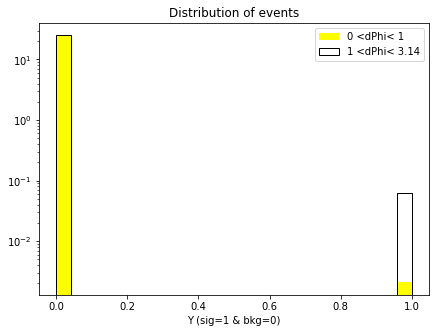

In [11]:
# visualizing the data
def select_from_train(zmin, zmax):
    
     # remove rows of dPhi out of range
    df_test_range = df[(df.dPhi > zmin) & (df.dPhi < zmax)]
    
    # decompose training data to features-labels-nuissance
    FW = df_test_range.loc[:,['Finalweight']]
    df_test_range = df_test_range.drop(['Finalweight'], axis=1)

    Z_full = df_test_range.loc[:,['dPhi']]
    df_test_range = df_test_range.drop(['dPhi'], axis=1)
                   
    Y_full = df_test_range.loc[:, ['Y']]          
    df_test_range = df_test_range.drop(['Y'], axis=1)
            
    X_full = df_test_range
    
    return X_full.values, Y_full.values, Z_full.values, FW.values


# get training data within range of sig-bkg using select_from_train function
X0, Y0, Z0 , FW0 = select_from_train(0, 1)
X1, Y1, Z1 , FW1 = select_from_train(1, 3.14)

fig, ax = plt.subplots(1, 1, figsize=(7, 5))

# show them... density=True normalizes them
bins = 25
ax.hist(Y0, bins=bins, density=True, weights=FW0, color='yellow', histtype='bar', label='0 <dPhi< 1 ')
ax.hist(Y1, bins=bins, density=True, weights=FW1, color='k', histtype='step', label='1 <dPhi< 3.14')   

ax.set_yscale('log')

# cosmetics
ax.legend(loc='best')
ax.set_title('Distribution of events')
ax.set_xlabel('Y (sig=1 & bkg=0)')\

del X0; del Y0; del Z0; del FW0
del X1; del Y1; del Z1; del FW1

It is clear that dPhi has good discrimination power with dPhi>1 representing most of the signal.

# <ins>I. Classification using MLP:<ins>

## 1) Pre-processing:

In [12]:
    # Train-Test-Split
df_train, df_test = train_test_split(df, train_size=0.6, test_size=0.4, shuffle=True, random_state=0)

In [13]:
    # identifying X,Y,Z and converting them to tensors
features = ['MET', 'MT', 'Jet2_pt','Jet1_pt', 'nLep', 'Lep_pt', 'Selected', 'nVeto', 'LT', 'HT', 'nBCleaned_TOTAL','nTop_Total_Combined', 'nJets30Clean',"Lep_relIso","Lep_miniIso","iso_pt","iso_MT2"]

# X -- event features
X_train = torch.tensor(df_train[features].values).to(device)
X_test = torch.tensor(df_test[features].values).to(device)

# Y -- label (1 for signal & 0 for bkg)
Y_train = torch.tensor(df_train[['Y']].values).to(device)
Y_test = torch.tensor(df_test[['Y']].values).to(device)

# Z -- nuissance parameter (dPhi)
Z_train = torch.tensor(df_train[['dPhi']].values).to(device)
Z_test = torch.tensor(df_test[['dPhi']].values).to(device)

# Finalweight -- cross-section
Finalweight_train = torch.tensor(df_train[['Finalweight']].values).to(device)
Finalweight_test = torch.tensor(df_test[['Finalweight']].values).to(device)

In [14]:
num_features = X_train.shape[1]
print("Number of trainable features is:", num_features)

Number of trainable features is: 17


### Dataloader:

In [15]:
import torchvision
from torch.utils.data import Dataset, DataLoader

class PhysDataset(Dataset):

    def __init__(self):
        self.x = X_train
        self.y = Y_train
        
        self.n_samples = self.x.shape[0]
        
    def __getitem__(self, index):
        return self.x[index], self.y[index]
        
    def __len__(self):
        return self.n_samples
    
dataset = PhysDataset()

In [16]:
    # this helps create a data loader which iterates over tuples of target/labels with specfied batch size
    # everytime the next function is called we receive the next batch sample & target until we cover all the data
    
train_loader = torch.utils.data.DataLoader(dataset, batch_size=2, shuffle=True)
next(iter(train_loader))

[tensor([[1.7873e+02, 3.9932e+01, 1.7326e+02, 4.1562e+02, 1.0000e+00, 1.2951e+02,
          1.0000e+00, 0.0000e+00, 3.0824e+02, 7.0838e+02, 1.0000e+00, 0.0000e+00,
          4.0000e+00, 2.1935e-03, 0.0000e+00, 6.2617e+00, 3.0284e+01],
         [4.3438e+02, 2.6670e+02, 5.0146e+02, 6.3413e+02, 1.0000e+00, 1.2689e+02,
          1.0000e+00, 0.0000e+00, 5.6127e+02, 2.3526e+03, 1.0000e+00, 3.0000e+00,
          1.1000e+01, 1.5922e-01, 0.0000e+00, 5.2531e+01, 0.0000e+00]],
        device='cuda:0', dtype=torch.float64), tensor([[0],
         [1]], device='cuda:0')]

## 2) Model of the MLP classifier:

In [17]:
class Classifier(nn.Module):
    
    def __init__(self, width, n_inputs):
        super(Classifier, self).__init__()
        self.width = width
    
        # input layer
        self.input = nn.Linear(n_inputs, width)
    
        # hidden layers
        self.h1 = nn.Linear(in_features=width, out_features=width)
        self.h2 = nn.Linear(in_features=width, out_features=width)
    
        # output layer
        self.output = nn.Linear(width, 1)

    def forward(self, x):
    
        # input layer
        x = F.relu(self.input(x))
    
        # hidden layers
        x = F.relu(self.h1(x))
        x = F.relu(self.h2(x))
        
        # output layer
        x = torch.sigmoid(self.output(x))
    
        return x

## 3) Training of the MLP classifier:

In [18]:
# function to help evaluate the training/test accuracies during training.. it compares predictions to labels
# we define a threshold at 0.5, with predictions below classified as bkg & predictions above classified as sig

def get_num_correct(x, y):
    return torch.round(x.float()).eq(y.float()).sum().item()

In [19]:
from tqdm import tqdm_notebook as tqdm
import time

def normal_training(epochs=20, batch_size = 291, learning_rate=0.001):        

    # create the network
    network = Classifier(128, n_inputs=num_features).to(device)

    # choose the criterion
    criterion = nn.BCELoss()

    # create the optimiser
    optimizer = torch.optim.Adam(network.parameters(), lr=learning_rate)
    
    # keep track of the losses
    losses = []
    losses_test = []

    avg_losses = []               ######## for plotting we need losses per epoch
    avg_losses_test = []

    # create a data loader to begin the training
    train_loader = torch.utils.data.DataLoader(dataset, batch_size)

    # start a timer
    begt = time.time()
    
    for epoch in tqdm(range(epochs)):
        
        # to evaluate accuracies while training
        correct_preds = 0
        correct_preds_test = 0
        
        for batch in tqdm(train_loader):
            
            X,Y = batch

            # forwardprop
            preds = network(X.float())
            loss = criterion(preds,Y.float())

            # backprop
            optimizer.zero_grad()                    ######## To avoid accumulating the gradients
            loss.backward()
            optimizer.step()

            losses.append(loss.to('cpu').detach().numpy())

            # feedback to assess training accuracy
            correct_preds += get_num_correct(preds, Y)
            
            
            # sample some test data for evaluation
            with torch.no_grad():
                indx = torch.randint(0, X_test.shape[0], size=(5000, ))
                X_t, Y_t = X_test[indx], Y_test[indx]
                output_test = network(X_t.float())
                loss_test = criterion(output_test, Y_t.float())

                losses_test.append(loss_test.to('cpu').detach().numpy())
                
                # feedback to assess test accuracy
                correct_preds_test += get_num_correct(output_test, Y_t)


        # calculate loss averages to use them in plots
        avg_losses.append(np.mean(losses)) 
        avg_losses_test.append(np.mean(losses_test))

        # evaluate the train/test accuracies
        train_accuracy = correct_preds * 100 / X_train.shape[0]
        test_accuracy = correct_preds_test * 100 / (X_t.shape[0] * X_train.shape[0] / batch_size)
        
        print("Epoch:", epoch+1, " - Loss:", round(loss.item(),5), " - Train accuracy: ", round(train_accuracy,2),  " - Test accuracy: ", round(test_accuracy,2))

    fig, ax = plt.subplots()
    ax.plot(range(len(avg_losses)), avg_losses, label='train loss')
    ax.plot(range(len(avg_losses_test)), avg_losses_test, label='test loss')
    ax.set_xlabel('Epochs')
    ax.set_ylabel('Classifier loss')
    ax.legend(loc='best')
    plt.show()
    
    print("Training time:", round(((time.time()-begt)/60),2),"min" )

    return network

Epoch: 1  - Loss: 0.14473  - Train accuracy:  95.14  - Test accuracy:  95.18


Epoch: 2  - Loss: 0.14307  - Train accuracy:  96.56  - Test accuracy:  96.6


Epoch: 3  - Loss: 0.14197  - Train accuracy:  96.74  - Test accuracy:  96.76


Epoch: 4  - Loss: 0.1398  - Train accuracy:  96.81  - Test accuracy:  96.82


Epoch: 5  - Loss: 0.135  - Train accuracy:  96.84  - Test accuracy:  96.86



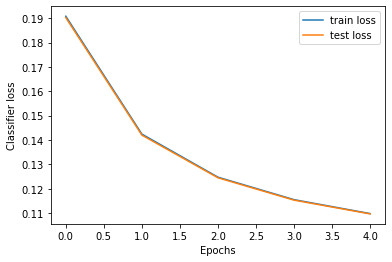

Training time: 3.69 min


In [20]:
clf = normal_training(epochs=5, batch_size = 291, learning_rate=0.001)

## 4) Evaluating the performance of the MLP classifier:

In [21]:
from matplotlib.lines import Line2D
from matplotlib.patches import Patch
import sklearn.metrics as metrics
from sklearn.metrics import roc_curve

In [22]:
def show_roc_curves(Y0, Y0_pred, Y1, Y1_pred, ax):    
    
    # compute the roc curves
    fpr0, tpr0, _ = roc_curve(Y0, Y0_pred.cpu().detach().numpy())
    roc_auc0 = metrics.auc(fpr0, tpr0)

    fpr1, tpr1, _ = roc_curve(Y1, Y1_pred.cpu().detach().numpy())
    roc_auc1 = metrics.auc(fpr1, tpr1)

    # draw the roc curves
    ax.plot(fpr0, tpr0, c='k', label='0 <dPhi< 1,   AUC = %0.2f' % roc_auc0)
    ax.plot(fpr1, tpr1, c='red', label='1 <dPhi < 3.14,   AUC = %0.2f' % roc_auc1)

    # cosmetics
    ax.legend(loc='best')
    ax.set_xlabel('False positive rate')
    ax.set_ylabel('True positive rate')
    ax.set_title('ROC curve')
    
    
def select_from_test(zmin, zmax):
    
    # get test data
    df_test_all = pd.concat([df_test[features], df_test[['Y']], df_test[['dPhi']], df_test[['Finalweight']]], axis = 1)
    
    # remove events of dPhi out of range
    df_test_range = df_test_all[(df_test_all.dPhi > zmin) & (df_test_all.dPhi < zmax)]
    
    # decompose test data to features-labels-nuissance-Finalweight
    FW = df_test_range.loc[:,['Finalweight']]
    df_test_range = df_test_range.drop(['Finalweight'], axis=1)

    Z_full = df_test_range.loc[:,['dPhi']]
    df_test_range = df_test_range.drop(['dPhi'], axis=1)
                   
    Y_full = df_test_range.loc[:, ['Y']]          
    df_test_range = df_test_range.drop(['Y'], axis=1)
            
    X_full = df_test_range
    
    return X_full.values, Y_full.values, Z_full.values, FW.values


def show_clf_output(Y0_pred, FW0, Y1_pred, FW1, ax):

    # show them... density=True normalizes them
    bins = 30
    ax.hist(Y0_pred.cpu().detach().numpy(), bins=bins, density=True, weights=FW0, color='k', histtype='step', label='0 <dPhi< 1 ')
    ax.hist(Y1_pred.cpu().detach().numpy(), bins=bins, density=True, weights=FW1, color='red', histtype='step', label='1 <dPhi< 3.14')   
    
    ax.set_yscale('log')

    # cosmetics
    ax.legend(loc='best')
    ax.set_title('Classifier output (sig+bkg events)')
    ax.set_xlabel('Classifier output')


def evaluate_classifier(clf):
    
    # get test data within range of sig-bkg using testFW function
    X0, Y0, Z0 , FW0 = select_from_test(0, 1)
    X1, Y1, Z1 , FW1 = select_from_test(1, 3.14)
    
    # compute the predictions
    Y0_pred = clf(torch.as_tensor(X0, dtype=torch.float).to(device))
    Y1_pred = clf(torch.as_tensor(X1, dtype=torch.float).to(device))    
    
    # plot
    fig, ax = plt.subplots(1, 2, figsize=(12, 5))
    
    show_roc_curves(Y0, Y0_pred, Y1, Y1_pred, ax[0])
    show_clf_output(Y0_pred, FW0, Y1_pred, FW1, ax[1])
    
    plt.show()

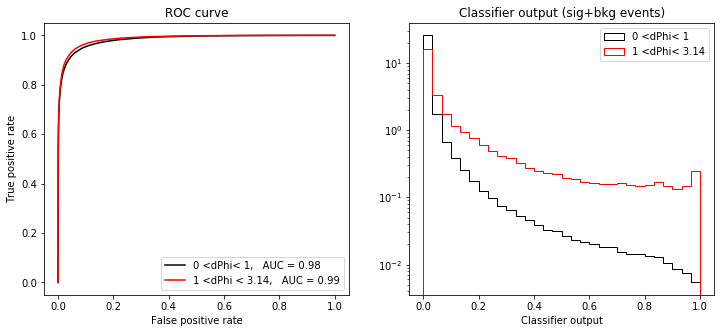

In [23]:
evaluate_classifier(clf)

# <ins>II. Classification using Adversarial Training:<ins>

## 1) Pre-processing:

In [24]:
# we need to define a new dataset class which now contains 3 items ~ X,Y,Z
class advDataset(Dataset):

    def __init__(self):
        self.x = X_train
        self.y = Y_train
        self.z = Z_train
        
        self.n_samples = self.x.shape[0]
        
    def __getitem__(self, index):
        return self.x[index], self.y[index], self.z[index]
        
    def __len__(self):
        return self.n_samples
    
adv_dataset = advDataset()

In [25]:
# create an instance of adversarial data loader to check that it contains a 3-tuple object
adv_train_loader = torch.utils.data.DataLoader(adv_dataset, batch_size=2, shuffle=True)
next(iter(adv_train_loader))

[tensor([[1.9530e+02, 1.7342e+01, 1.7214e+02, 3.5860e+02, 1.0000e+00, 1.1062e+02,
          1.0000e+00, 0.0000e+00, 3.0593e+02, 7.1699e+02, 2.0000e+00, 1.0000e+00,
          5.0000e+00, 0.0000e+00, 0.0000e+00, 6.6938e+01, 0.0000e+00],
         [4.6462e+02, 5.1535e+01, 1.7726e+02, 7.4769e+02, 1.0000e+00, 9.4597e+01,
          1.0000e+00, 0.0000e+00, 5.5922e+02, 1.0146e+03, 1.0000e+00, 0.0000e+00,
          3.0000e+00, 1.7649e-02, 5.6366e-03, 9.9900e+02, 9.9900e+02]],
        device='cuda:0', dtype=torch.float64), tensor([[0],
         [0]], device='cuda:0'), tensor([[0.1180],
         [0.2464]], device='cuda:0', dtype=torch.float64)]

## 2) Model of a regressor:

In [26]:
class Regressor(nn.Module):
    
    def __init__(self, width):
        super(Regressor, self).__init__()
        self.width = width
    
        # input layer
        self.input = nn.Linear(1, width)
    
        # hidden layers
        self.h1 = nn.Linear(width, width)
        self.h2 = nn.Linear(width, width)
    
        # output layer
        self.output = nn.Linear(width, 1)

    def forward(self, x):
    
        # input layer
        x = F.relu(self.input(x))
    
        # hidden layers
        x = F.relu(self.h1(x))
        x = F.relu(self.h2(x))
        
        # output layer
        x = self.output(x)
    
        return x

## 3) Adversarial training:

In [27]:
def adversarial_training(epochs=20, batch_size = 291, learning_rate=0.001, lam=0.75):
    
    # create the classifier and the adversary networks
    clf = Classifier(128, n_inputs=num_features).to(device)
    adv = Regressor(50).to(device)

    # choose the criterions
    clf_criterion = nn.BCELoss()
    adv_criterion = nn.MSELoss()

    # create optimisers (larger learning rate for the adversary )
    clf_optimiser = torch.optim.Adam(clf.parameters(), lr=learning_rate)
    adv_optimiser = torch.optim.Adam(adv.parameters(), lr=5*learning_rate)

    # keep track of the losses
    clf_losses = []
    adv_losses = []
    clf_losses_test = []
    adv_losses_test = []
    
    clf_avg_losses = []
    clf_avg_losses_test = []
    adv_avg_losses = []
    
    # create a data loader to begin the training
    adv_train_loader = torch.utils.data.DataLoader(adv_dataset, batch_size)
    
    # start a timer
    begt = time.time()   
    
    for epoch in tqdm(range(epochs)):
        
        # to evaluate accuracies while training
        correct_preds = 0
        correct_preds_test = 0
        
        for batch in tqdm(adv_train_loader):
            
            X,Y,Z = batch
    
            ##############################
            # Update the adversary network
            ##############################

            M = 5
            for _ in range(M):
                # forwardprop
                clf_output = clf(X.float())
                adv_output = adv(clf_output)

                # get the adversary loss
                adv_loss = adv_criterion(adv_output, Z.float())

                # backprop for the adversary using the adverary loss
                adv.zero_grad()
                adv_loss.backward()
                adv_optimiser.step()

            adv_losses.append(adv_loss.to('cpu').detach().numpy())

            ##############################
            # Update the classifier network
            ##############################

            # forwardprop
            clf_output = clf(X.float())
            adv_output = adv(clf_output)

            # make the combined loss: note the minus sign!
            clf_loss = clf_criterion(clf_output, Y.float())
            adv_loss = adv_criterion(adv_output, Z.float())
            comb_loss = clf_loss - lam * adv_loss

            # backprop for the classifier using the combined loss
            clf.zero_grad()
            comb_loss.backward()
            clf_optimiser.step()

            clf_losses.append(clf_loss.to('cpu').detach().numpy())

            # feedback to assess training accuracy
            correct_preds += get_num_correct(clf_output, Y)


            # sample some test data for evaluation
            with torch.no_grad():
                indx = torch.randint(0, X_test.shape[0], size=(5000, ))
                X_t, Y_t = X_test[indx], Y_test[indx]
                output_test = clf(X_t.float())
                loss_test = clf_criterion(output_test, Y_t.float())

                clf_losses_test.append(loss_test.to('cpu').detach().numpy())
                    
                # feedback to assess test accuracy
                correct_preds_test += get_num_correct(output_test, Y_t)
        
        
        # calculate loss averages to use them in plots
        clf_avg_losses.append(np.mean(clf_losses)) 
        clf_avg_losses_test.append(np.mean(clf_losses_test))
        adv_avg_losses.append(np.mean(adv_losses))
        
        # evaluate the train/test accuracies
        train_accuracy = correct_preds * 100 / X_train.shape[0]
        test_accuracy = correct_preds_test * 100 / (X_t.shape[0] * X_train.shape[0] / batch_size)
    
        print("Epoch:", epoch+1, " - clf loss:", round(clf_loss.item(),5), " - adv loss:", round(adv_loss.item(),5), " - Train accuracy: ", round(train_accuracy,2),  " - Test accuracy: ", round(test_accuracy,2))

    fig, ax = plt.subplots(2, sharex=True)
    ax[0].plot(range(len(clf_avg_losses)), clf_avg_losses, label='train loss')
    ax[0].plot(range(len(clf_avg_losses_test)), clf_avg_losses_test, label='test loss')
    ax[0].set_ylabel('Classifier loss')
    ax[0].legend(loc='best')
    ax[1].plot(range(len(adv_avg_losses)), adv_avg_losses, color='k')
    ax[1].set_ylabel('Adversary loss')
    ax[1].set_xlabel('Training step')
    plt.show()
    
    print("Training time:", round(((time.time()-begt)/60),2),"min" )

    return clf

Epoch: 1  - clf loss: 0.20484  - adv loss: 0.36784  - Train accuracy:  93.05  - Test accuracy:  93.06


Epoch: 2  - clf loss: 0.20927  - adv loss: 0.4026  - Train accuracy:  94.24  - Test accuracy:  94.26


Epoch: 3  - clf loss: 0.20678  - adv loss: 0.39881  - Train accuracy:  94.47  - Test accuracy:  94.49


Epoch: 4  - clf loss: 0.21678  - adv loss: 0.42119  - Train accuracy:  94.49  - Test accuracy:  94.51


Epoch: 5  - clf loss: 0.19032  - adv loss: 0.39301  - Train accuracy:  94.51  - Test accuracy:  94.53



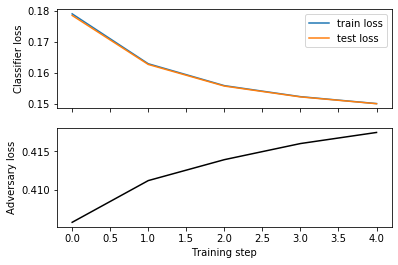

Training time: 13.94 min


In [28]:
adv = adversarial_training(epochs=5, batch_size = 291, learning_rate=0.001, lam=0.75)

## 4) Evaluating the Adversarial training:

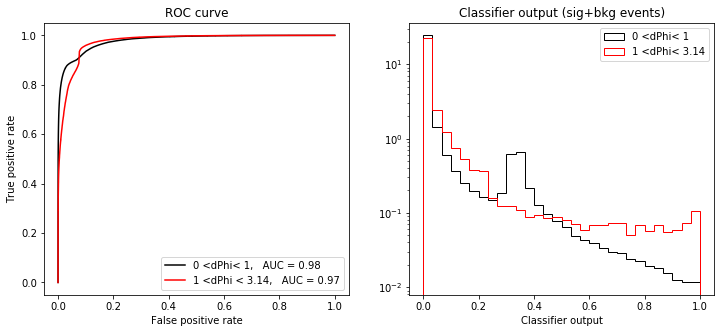

In [29]:
evaluate_classifier(adv)

# <ins>III. Comparing MLP vs Adversarial Networks in the decorrelation:<ins>

In [30]:
def testBkg():
    """
    Returns:
    4-tuple -- bkg data comprising of: X,Y,dPhi,Finalweight
    """
    # get test data
    df_test_all = pd.concat([df_test[features], df_test[['Y']], df_test[['dPhi']], df_test[['Finalweight']]], axis = 1)
  
    # keep only rows which correspond to bkg events
    df_test_bkg = df_test_all[(df_test_all.Y==0)]
    
    # decompose test data to features-labels-nuissance-Finalweight
    FW = df_test_bkg.loc[:,['Finalweight']]
    df_test_bkg = df_test_bkg.drop(['Finalweight'], axis=1)

    Z_full = df_test_bkg.loc[:,['dPhi']]
    df_test_bkg = df_test_bkg.drop(['dPhi'], axis=1)
                   
    Y_full = df_test_bkg.loc[:, ['Y']]          
    df_test_bkg = df_test_bkg.drop(['Y'], axis=1)
    
    X_full = df_test_bkg
    
    return X_full.values, Y_full.values, Z_full.values, FW.values


def correlation(clf, clf_type):
    """
    Returns:
    ratio -- the ratio which measures the decorrelation intended
    
    Displays:
    graph -- a density graph of the classifier output for bkg data over the whole range of dPhi
    """
    X0, Y0, Z0, FW0 = testBkg()
    Y0_pred = clf(torch.as_tensor(X0, dtype=torch.float).to(device))   ####This is the classifier output
       
    C = Y0_pred.cpu().detach().numpy()  
    
    dl=0; ul=0; dr=0; ur=0
    for i in range(Y0.size):
        if (C[i]<0.5 and Z0[i]<1.57):
            dl=dl+1*FW0[i]
                    
        if (C[i]>0.5 and Z0[i]<1.57):
            dr=dr+1*FW0[i]          
                                
        if (C[i]<0.5 and Z0[i]>1.57):
            ul=ul+1*FW0[i]
    
        if (C[i]>0.5 and Z0[i]>1.57):
            ur=ur+1*FW0[i]

    Ratio = (ul/dl)/(ur/dr)[0]
    
    fig = plt.figure()
    fig, ax = plt.subplots(1, figsize=(10, 5))
    plt.hist2d(C.reshape(-1), Z0.reshape(-1), bins=500, weights=FW0.reshape(-1), norm=mpl.colors.LogNorm())
    fig.suptitle('Correlation of ' + clf_type + ' network', fontsize=20)

    plt.xlabel('clf output', fontsize=18)
    plt.ylabel('dPhi', fontsize=16)
    plt.show()
    
    return Ratio

<Figure size 432x288 with 0 Axes>

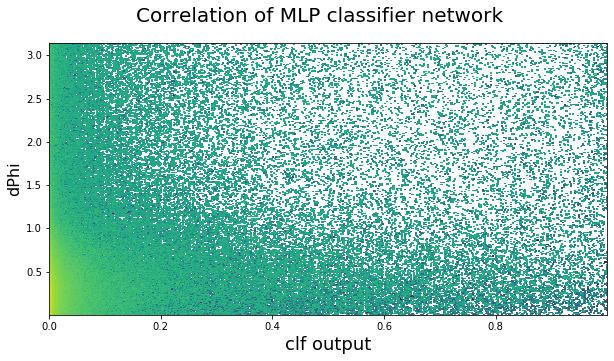

The ratio for the MLP classifier is: [0.08401882]


In [31]:
clf_ratio = correlation(clf, 'MLP classifier')
print("The ratio for the MLP classifier is:", clf_ratio)

<Figure size 432x288 with 0 Axes>

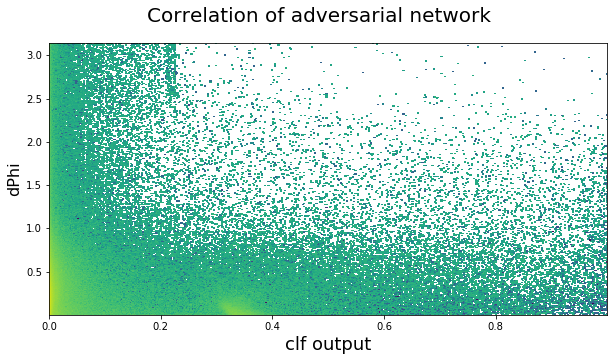

The ratio for the adversarial network is: [0.78332007]


In [32]:
adv_ratio = correlation(adv, 'adversarial')
print("The ratio for the adversarial network is:", adv_ratio)